In [1]:
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
%matplotlib inline

In [2]:
tf.random.set_seed(272) 
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
print(vgg)

80150528/80134624 [==============================] - 1s 0us/step


In [3]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [4]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

(1, 400, 400, 3)


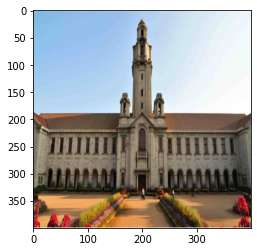

In [5]:
content_image= np.array(Image.open("/content/content_2.jpg").resize((400,400)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


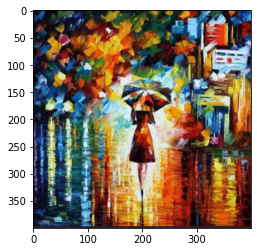

In [6]:
style_image= np.array(Image.open("/content/style_3.jpg").resize((400,400)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


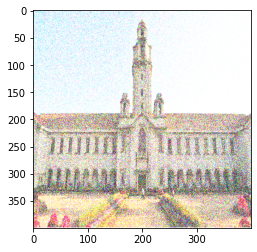

In [7]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [8]:
content_layer = [('block5_conv4', 1)]

STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

In [9]:
def get_layer_outputs(vgg, layer_names):
    # layer_names has 'layer' elements in it.
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [10]:
vgg_content_outputs = get_layer_outputs(vgg, content_layer)
vgg_style_outputs = get_layer_outputs(vgg, STYLE_LAYERS)

In [11]:
def compute_content_cost(content_output, generated_output):
    
    a_C = content_output
    a_G = generated_output
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])
   
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)

    return J_content

In [12]:
def gram_matrix(A):

    return tf.linalg.matmul(A, tf.transpose(A))

In [13]:
def compute_layer_style_cost(a_S, a_G):
   
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=(n_H* n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G, shape=(n_H* n_W,n_C)))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = (1/(4 * (n_H*n_W*n_C)**2)) * tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    return J_style_layer

In [14]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
   
    J_style = 0
    a_S = style_image_output
    a_G = generated_image_output
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [15]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
   
    return alpha* J_content + beta * J_style

In [16]:
def clip_0_1(image):
    
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G_content = vgg_content_outputs(generated_image)
        a_G_style = vgg_style_outputs(generated_image)
        
        J_style = compute_style_cost(a_S, a_G_style)

        J_content = compute_content_cost(a_C, a_G_content)
        
        J = total_cost(J_content, J_style)  
   
    grad = tape.gradient(J, generated_image)

    return J, grad

In [18]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_content_outputs(preprocessed_content)

In [19]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_style_outputs(preprocessed_style)

Epoch 0 


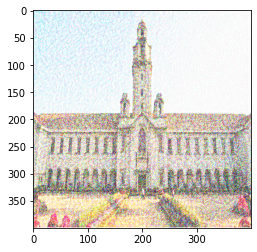

Epoch 1000 


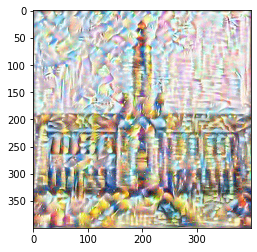

Epoch 2000 


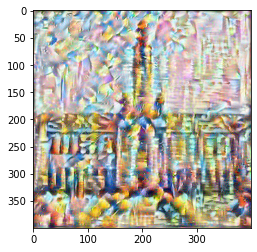

Epoch 3000 


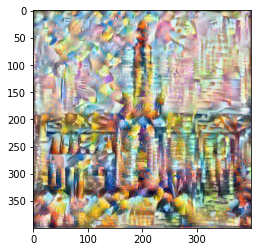

Epoch 4000 


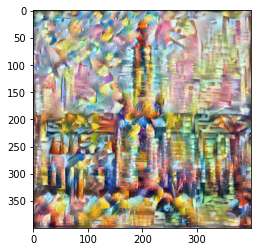

In [20]:
generated_image =  tf.Variable(tf.image.convert_image_dtype(generated_image, tf.float32))
epochs = 4001
for i in range(epochs):
    loss,grad=train_step(generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    if i % 1000 == 0:
        print(f"Epoch {i} ")
    if i % 1000 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/output/image_{i}.jpg")
        plt.show() 